In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 10)

In [5]:
#%% settings
#for windows
#file = 'sample_data\\201805\\RL7785--1K-20180517102718_crv.csv'
file = 'sample_data/201805/RL7797--1K-20180525135150_crv.csv'
#file_rlt = 'sample_data\\201805\\RL7785--1K-20180517102718_rlt.csv'
file_rlt = 'sample_data/201805/RL7797--1K-20180525135150_rlt.csv'


In [10]:
#%% read files and parameters
data = pd.read_csv(file, sep=',', encoding='shift_jis', skiprows=1, index_col=0)
data_rlt = pd.read_csv(file_rlt, sep=',', skiprows=[1,2], index_col=0, encoding='shift_jis')
data.head()

,mm,N,mm.1,N.1,mm.2,N.2,mm.3,N.3,mm.4,N.4
1,0.000,0.10,0.000,0.10,0.000,0.10,0.000,0.11,0.000,0.11
2,0.001,0.18,0.001,0.14,0.001,0.12,0.001,0.18,0.001,0.12
3,0.002,0.26,0.002,0.24,0.002,0.22,0.002,0.26,0.002,0.20
4,0.003,0.37,0.003,0.35,0.003,0.34,0.003,0.35,0.003,0.25
5,0.004,0.43,0.004,0.46,0.004,0.43,0.004,0.47,0.004,0.32


In [11]:
L = 64  # span
b = float(data_rlt.iloc[2, 3]) # width of first specimen
h = float(data_rlt.iloc[2, 4]) # height of first specimen
print('span, width, height of first specimen:', L, ',', b, ',', h)

span, width, height of first specimen: 64 , 3.8339999999999996 , 15106.0


In [12]:
#cut out curve of first specimen
col = ['mm', 'N']
data = data.reindex(columns=col)
data

,mm,N
1,0.000,0.10
2,0.001,0.18
3,0.002,0.26
4,0.003,0.37
5,0.004,0.43
...,...,...
483,4.249,255.00
484,4.349,255.00
485,NaN,NaN
486,NaN,NaN


In [13]:
#%% convert (mm, N) to (%, MPa)
# sigma = 3*F*L / (2*b*h^2)
# epsilon = 6*100*s*h / (L^2)
# F: load, L:span = 64 mm, b:width, h:height, s=strain/mm

data['strain'] = data['mm'] * 6 * 100 * h / L / L
data['stress'] = data['N'] * 3 * L / (2 * b * h * h)
data.dropna(subset=['mm'], inplace=True)

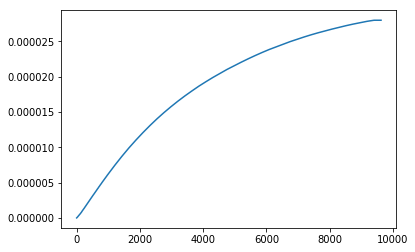

In [14]:
plt.plot(data['strain'], data['stress'])
plt.xlabel = 'strain / %'
plt.ylabel = 'stress / N'
plt.show()

In [15]:
#%% data thinnings
max_strain = 10
interval = 0.1
interval_steps = int(max_strain/interval)
marker = pd.DataFrame({'strain': np.round(np.linspace(0, max_strain, interval_steps, endpoint=False), 2), 'marker': True})
data_marked = pd.merge(data, marker, on='strain', how='outer')
data_marked.sort_values(by=['strain'], inplace=True)
data_marked.rename(data_marked['strain'], inplace=True)
data_marked.interpolate(method='slinear', limit=1, inplace=True)

In [16]:
data_marked['marker'].fillna('False', inplace=True)
data_skipped = data_marked[data_marked['marker']==True]
data_skipped

,mm,N,strain,stress,marker
0.0,0.000000,0.100000,0.0,1.097287e-08,True
0.1,0.000045,0.103615,0.1,1.136957e-08,True
0.2,NaN,NaN,0.2,NaN,True
0.3,NaN,NaN,0.3,NaN,True
0.4,NaN,NaN,0.4,NaN,True
...,...,...,...,...,...
9.5,NaN,NaN,9.5,NaN,True
9.6,NaN,NaN,9.6,NaN,True
9.7,NaN,NaN,9.7,NaN,True
9.8,NaN,NaN,9.8,NaN,True


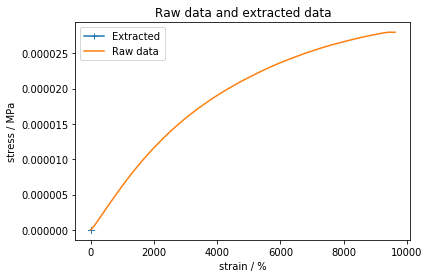

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(data_skipped['strain'], data_skipped['stress'], marker='+', label='Extracted')
ax.plot(data['strain'], data['stress'], label='Raw data')
ax.set_xlabel('strain / %')
ax.set_ylabel('stress / MPa')
ax.set_title('Raw data and extracted data')
ax.legend(loc='best')
plt.show()

In [18]:
thinnedSS = data_skipped['stress']
thinnedSS

0.0    1.097287e-08
0.1    1.136957e-08
0.2             NaN
0.3             NaN
0.4             NaN
           ...     
9.5             NaN
9.6             NaN
9.7             NaN
9.8             NaN
9.9             NaN
Name: stress, Length: 100, dtype: float64

In [19]:
    file = {'name':'RL7785',
            'crv':'sample_data/201805/RL7785--1K-20180517102718_crv.csv', 
            'rlt':'sample_data/201805/RL7785--1K-20180517102718_rlt.csv',
            'set':'sample_data/201805/RL7785--1K-20180517102718_set.csv'}
    #for windows
    #file = {'crv':'sample_data\\201805\\RL7785--1K-20180517102718_crv.csv', 
    #        'rlt':'sample_data\\201805\\RL7785--1K-20180517102718_rlt.csv',
    #        'set':'sample_data\\201805\\RL7785--1K-20180517102718_set.csv'}
    file['crv']

'sample_data/201805/RL7785--1K-20180517102718_crv.csv'

In [20]:
def thinningSS(file, max_strain=10, interval=0.1):
    '''a function to conduct data thinning of SS curve at range (0, MAX_STRAIN), with INTERVAL
    This returns np.series of stress with strain in the index. 
    FILE should be passed as dictionary containing following: 
        'name': name of sample like 'RL7785'
        'crv': path(relative) of xxx_crv.csv file
        'rlt': path(relative) of xxx_rlt.csv file
        'set': path(relative) of xxx_set.csv file
    '''
    
    # read files and parameters
    data = pd.read_csv(file['crv'], sep=',', encoding='shift_jis', skiprows=1, index_col=0)
    data_rlt = pd.read_csv(file['rlt'], sep=',', encoding='shift_jis')
    L = 64  # span
    b = float(data_rlt.iloc[2, 3]) # width of first specimen
    h = float(data_rlt.iloc[2, 4]) # height of first specimen
    #print('span, width, height of first specimen:', L, ',', b, ',', h)#cut out curve of first specimen
    col = ['mm', 'N']
    data = data.reindex(columns=col)
    data.dropna(subset=['mm'], inplace=True)
    
    #%% convert (mm, N) to (%, MPa)
    # sigma = 3*F*L / (2*b*h^2)
    # epsilon = 6*100*s*h / (L^2)
    # F: load, L:span = 64 mm, b:width, h:height, s=strain/mm
    data['strain'] = data['mm'] * 6 * 100 * h / L / L
    data['stress'] = data['N'] * 3 * L / (2 * b * h * h)
    
    #%% data thinnings
    interval_steps = int(max_strain/interval)
    marker = pd.DataFrame({'strain': np.round(np.linspace(0, max_strain, interval_steps, endpoint=False), 2), 'marker': True})
    data_marked = pd.merge(data, marker, on='strain', how='outer')
    data_marked.rename(data_marked['strain'], inplace=True)
    data_marked.sort_values(by=['strain'], inplace=True)
    data_marked.interpolate(method='slinear', limit=1, inplace=True)
    data_marked['marker'].fillna('False', inplace=True)
    data_skipped = data_marked[data_marked['marker']==True]
    thinnedSS = data_skipped['stress']
    thinnedSS.name = file['name']
    
    return thinnedSS


In [21]:
test = thinningSS(file)

# From here: data picking 

In [31]:
#file_rlt = 'sample_data\\201805\\RL7785--1K-20180517102718_rlt.csv'
file_rlt = 'sample_data/201805/RL7797--1K-20180525135150_rlt.csv'

data_rlt = pd.read_csv(file_rlt, sep=',', skiprows=[1,2], index_col=0, encoding='shift_jis')
parameters = ['幅', '厚さ', '弾性率', '最大点', '破壊点', '最大点.1', '破壊点.1']
data_rlt = data_rlt.loc[['単純平均', '標準偏差'], parameters]
data_rlt.index = ['average', 'stdev']
data_rlt.columns = ['width', 'height', 'FM', 'FS_max', 'FS_break', 'FE_max', 'FE_break']
data_rlt = data_rlt.values
data_flattened = [item for sublist in data_rlt for item in sublist] #see below
parameters = ['width', 'height', 'FM', 'FS_max', 'FS_break', 'FE_max', 'FE_break', 
              'd_width', 'd_height', 'd_FM', 'd_FS_max', 'd_FS_break', 'd_FE_max', 'd_FE_break']
data_rlt = pd.Series(data_flattened, index=parameters) 
data_rlt

width             9.841
height            3.831
FM            15169.000
FS_max          170.400
FS_break        170.200
                ...    
d_FM            131.000
d_FS_max          1.500
d_FS_break        1.500
d_FE_max          0.080
d_FE_break        0.080
Length: 14, dtype: float64

In [33]:
def parameters(file):
    '''a function to pick following parameters as pd.Series: 
    parameters = ['width', 'height', 'FM', 'FS_max', 'FS_break', 'FE_max', 'FE_break', 
              'd_width', 'd_height', 'd_FM', 'd_FS_max', 'd_FS_break', 'd_FE_max', 'd_FE_break']
    FILE should be passed as dictionary containing following: 
        'name': name of sample like 'RL7785'
        'crv': path(relative) of xxx_crv.csv file
        'rlt': path(relative) of xxx_rlt.csv file
        'set': path(relative) of xxx_set.csv file '''

    file_rlt = file['rlt']
    data_rlt = pd.read_csv(file_rlt, sep=',', skiprows=[1,2], index_col=0, encoding='shift_jis')
    parameters = ['幅', '厚さ', '弾性率', '最大点', '破壊点', '最大点.1', '破壊点.1']
    data_rlt = data_rlt.loc[['単純平均', '標準偏差'], parameters]
    data_rlt.index = ['average', 'stdev']
    data_rlt.columns = ['width', 'height', 'FM', 'FS_max', 'FS_break', 'FE_max', 'FE_break']
    data_rlt = data_rlt.values
    data_flattened = [item for sublist in data_rlt for item in sublist] #see below
    parameters = ['width', 'height', 'FM', 'FS_max', 'FS_break', 'FE_max', 'FE_break', 
                  'd_width', 'd_height', 'd_FM', 'd_FS_max', 'd_FS_break', 'd_FE_max', 'd_FE_break']
    data_rlt = pd.Series(data_flattened, index=parameters) 
    data_rlt.name = file['name']
    return data_rlt

In [34]:
parameters(file)

width             9.816
height            3.944
FM            10020.000
FS_max           88.600
FS_break         87.100
                ...    
d_FM             48.000
d_FS_max          1.500
d_FS_break        2.300
d_FE_max          0.080
d_FE_break        0.080
Name: RL7785, Length: 14, dtype: float64